In [2]:
from DataManagement.data_manager import DataManager
from DataManagement.coin_data import CoinData

# libs
import pandas as pd
import numpy as np

# plotting
import seaborn as sn

In [3]:
data_manager = DataManager()

In [4]:
coin_symbol_list = ["BTCUSDT", "ETHUSDT", "ADAUSDT"]
feature = "close_pct"
kline_size = "1h"

In [5]:
coin_data_list = [data_manager.get_historical_data_CoinData(coin_symbol, kline_size="1h") for coin_symbol in coin_symbol_list]

In [29]:
btc = coin_data_list[0].df
eth = coin_data_list[1].df

27877

# Join close_pct columns of all coins togther

In [98]:
df = pd.DataFrame(index=coin_data_list[0].df.index)

for coin_data in coin_data_list:
    df = df.join(coin_data.df[feature], how="outer", rsuffix=f"_{coin_data.coin_symbol}", on="timestamp")
df.rename(columns={"close_pct":f"close_pct_{coin_data_list[0].coin_symbol}"}, inplace=True)    
df.dropna(inplace=True, how="any")
df.drop(columns=["timestamp"])
df.set_index("timestamp")

,close_pct_BTCUSDT,close_pct_ETHUSDT,close_pct_ADAUSDT
timestamp,,,
2018-04-17 05:00:00,-0.005853,-0.004019,-0.017402
2018-04-17 06:00:00,0.005262,0.004371,-0.020458
2018-04-17 07:00:00,0.014136,0.012821,0.001325
2018-04-17 08:00:00,-0.000842,0.004161,-0.002607
2018-04-17 09:00:00,0.001575,0.003156,-0.003706
...,...,...,...
2021-06-24 05:00:00,0.013385,0.012385,-0.002755
2021-06-24 06:00:00,0.000704,-0.000202,0.034149
2021-06-24 07:00:00,-0.004590,-0.004414,-0.007495


In [121]:
resampled_list = list(df.resample(rule="1d"))
result = np.empty(shape=(3,3,len(resampled_list)))
i = 0
for timestamp, temp_df in resampled_list:
    temp = temp_df.corr().to_numpy()
    # result = np.append(result, temp, axis=0)
    result[i] = temp
    i+=1

ValueError: could not broadcast input array from shape (3,3) into shape (3,1165)

In [108]:
c = ['close_pct_BTCUSDT', 'close_pct_ETHUSDT', 'close_pct_ADAUSDT']

In [109]:
mean_corr_df = pd.DataFrame(index= c,columns=c, data=result.mean(axis=0))

In [110]:
mean_corr_df

,close_pct_BTCUSDT,close_pct_ETHUSDT,close_pct_ADAUSDT
close_pct_BTCUSDT,1.000000,0.830597,0.472386
close_pct_ETHUSDT,0.830597,1.000000,0.506630
close_pct_ADAUSDT,0.472386,0.506630,1.000000


In [111]:
df.corr()

,close_pct_BTCUSDT,close_pct_ETHUSDT,close_pct_ADAUSDT
close_pct_BTCUSDT,1.000000,0.817159,0.679435
close_pct_ETHUSDT,0.817159,1.000000,0.735037
close_pct_ADAUSDT,0.679435,0.735037,1.000000


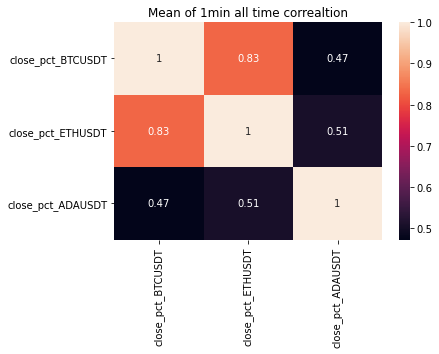

In [117]:
sn.heatmap(mean_corr_df, annot=True).set(title='Mean of 1min all time correaltion');